<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled140.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simulating step 0... Cautious: 2500 | Readthrough: 2500
Simulating step 500... Cautious: 0 | Readthrough: 0
Simulating step 1000... Cautious: 0 | Readthrough: 0
Simulating step 1500... Cautious: 0 | Readthrough: 0

--- KNOCKOUT at step 1500! ---
Cautious strategy is extinct. Readthrough wins.


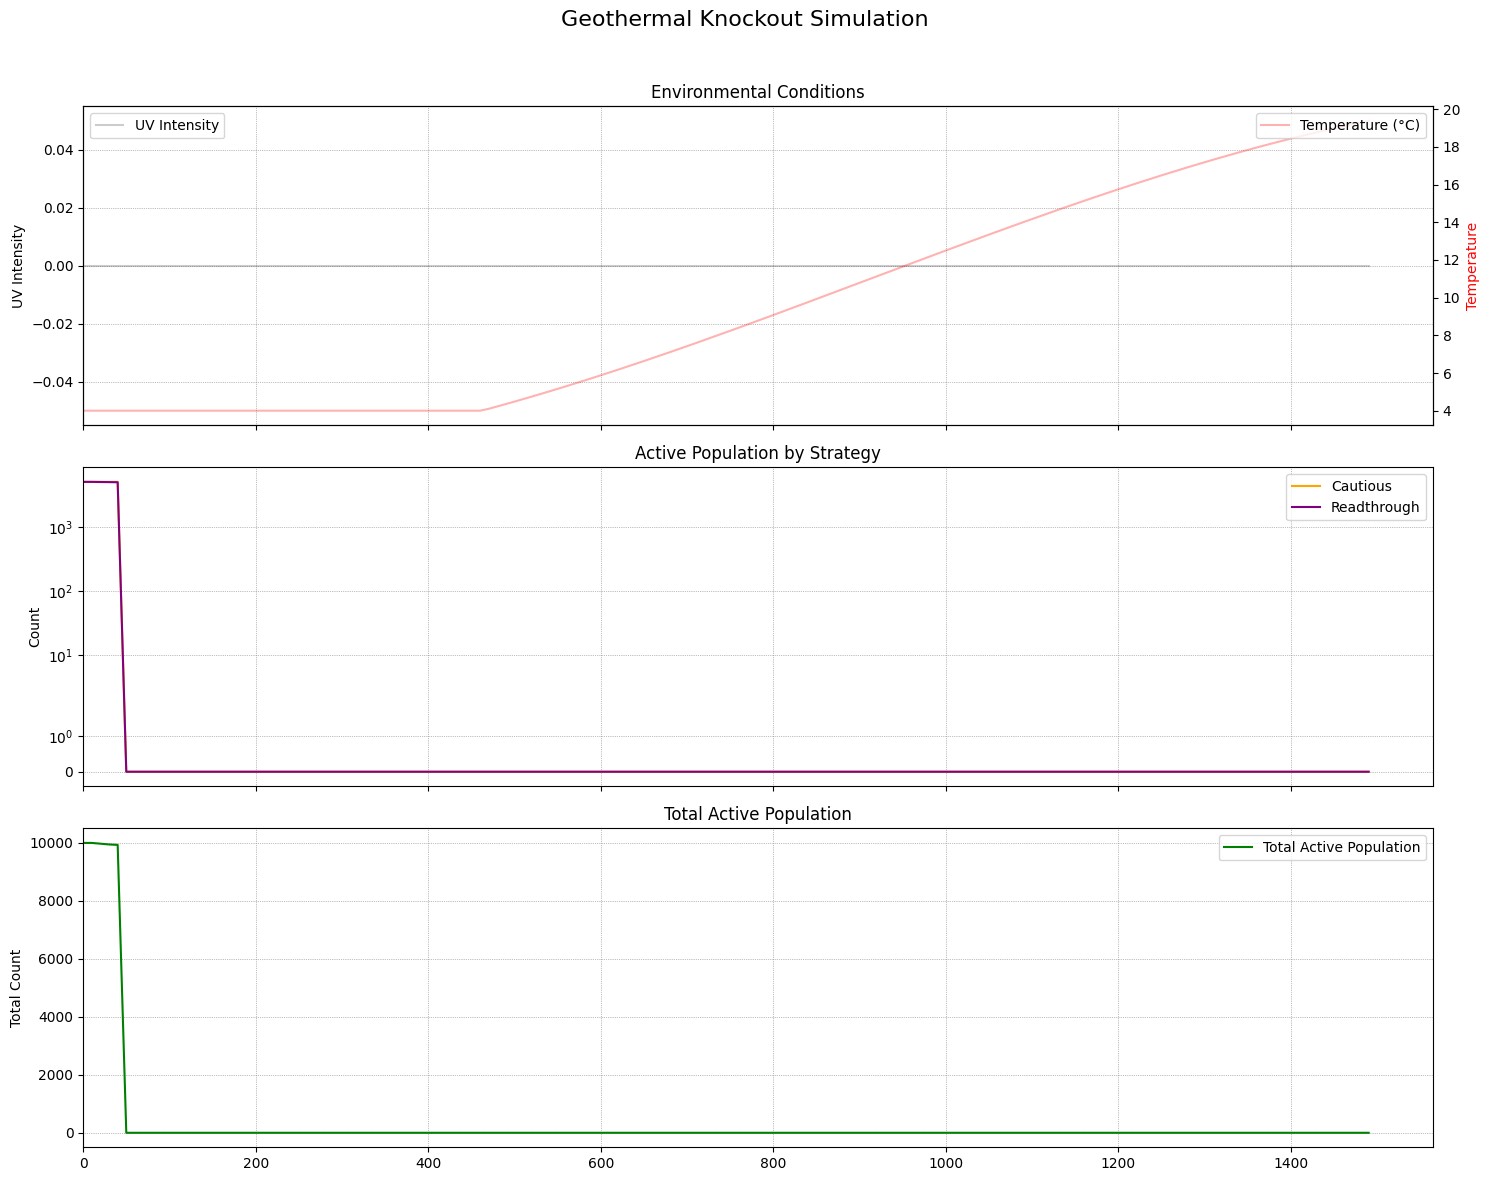

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import pickle
import os

# --- 1. Environment Class ---
class Environment:
    def __init__(self, total_sim_steps, days_per_cycle=50):
        self.total_sim_steps, self.days_per_cycle, self.time = total_sim_steps, days_per_cycle, 0
        num_years = max(1, total_sim_steps / (365 * days_per_cycle))
        steps_per_year = 365 * days_per_cycle

        daily_uv_cycle = np.sin(np.linspace(0, 2 * np.pi, days_per_cycle)); daily_uv_cycle[daily_uv_cycle < 0] = 0
        daily_temp_swing = -4 * np.cos(np.linspace(0, 2 * np.pi, days_per_cycle))

        full_uv, full_resources, full_temp = [], [], []
        for _ in range(int(np.ceil(num_years))):
            uv_severity = np.random.uniform(0.8, 1.25)
            resource_bounty = np.random.uniform(0.8, 1.25)

            seasonal_cycle = np.sin(np.linspace(0, 2 * np.pi, steps_per_year))
            seasonal_temp_base = 15 - 10 * np.cos(np.linspace(0, 2 * np.pi, steps_per_year)) # Temperate: 5°C to 25°C

            seasonal_amplitude_mod = (0.225 * seasonal_cycle + 0.725) * uv_severity
            seasonal_resource_mod = (-0.20 * seasonal_cycle + 0.80) * resource_bounty

            year_resources = 1200 * seasonal_resource_mod
            year_uv = [daily_uv_cycle[i % days_per_cycle] * seasonal_amplitude_mod[i] for i in range(steps_per_year)]

            # --- NEW: Geothermal heat provides a temperature floor ---
            GEOTHERMAL_BASE_TEMP = 4.0
            year_temp = []
            for i in range(steps_per_year):
                solar_temp = seasonal_temp_base[i] + daily_temp_swing[i % days_per_cycle]
                final_temp = max(GEOTHERMAL_BASE_TEMP, solar_temp)
                year_temp.append(final_temp)

            full_uv.extend(year_uv)
            full_resources.extend(year_resources)
            full_temp.extend(year_temp)

        self.uv_intensity = np.array(full_uv)
        self.external_resources = np.array(full_resources)
        self.temperature = np.array(full_temp)

    def get_current_uv(self):
        return self.uv_intensity[self.time % len(self.uv_intensity)]
    def get_current_resources(self):
        return self.external_resources[self.time % len(self.external_resources)]
    def get_current_temperature(self):
        return self.temperature[self.time % len(self.temperature)]
    def step(self):
        self.time += 1

# --- 2. Protoribosome Class ---
class Protoribosome:
    def __init__(self, env, strategy, initial_sequence, initial_mass=100.0):
        self.env, self.strategy, self.rna_sequence = env, strategy, list(initial_sequence)
        self.rna_mass = initial_mass
        self.atp_pool, self.mcyw_peptide_pool, self.other_peptide_pool = 500.0, 50.0, 5.0
        self.rna_damage_level = 0.0

        self.location = 'dark_zone'
        self.status = 'ACTIVE'

        self.metabolic_efficiency = 1.0
        self.uv_damage_rate_per_uv = 1.2
        self.repair_rate, self.repair_atp_cost = 0.5, 0.0025
        self.uv_protection_factor, self.damage_tolerance_threshold = 0.01, 3.0
        self.atp_generation_rate_per_mcyw_uv = 0.15
        self.baseline_atp_chemosynthesis = 1.5
        self.protein_synthesis_rate = 0.20
        self.replication_rate = 0.05
        self.atp_degradation_rate = 0.025
        self.mutation_prob = 0.004
        self.growth_rate = 0.1
        self.optimal_temp = 25.0
        self.temp_tolerance = 15.0

    def get_peptide_type(self):
        codons = ["".join(self.rna_sequence[i:i+3]) for i in range(0, len(self.rna_sequence), 3)]
        if any(c in {'UGU', 'UGC', 'UAU', 'UAC', 'UGG'} for c in codons):
            return "MCYW"
        return "XXXX"

    def has_stop_codon(self):
        return any(c in {'UAA', 'UAG', 'UGA'} for c in ["".join(self.rna_sequence[i:i+3]) for i in range(0, len(self.rna_sequence), 3)])

    def _decide_zone_transition(self):
        if self.location == 'dark_zone' and self.atp_pool < 450:
            self.location = 'light_zone'
        elif self.location == 'light_zone' and self.rna_damage_level > self.damage_tolerance_threshold * 0.75:
            self.location = 'dark_zone'

    def _apply_uv_damage(self, current_uv):
        if self.location == 'dark_zone' or current_uv <= 0:
            self.rna_damage_level = max(0, self.rna_damage_level - self.repair_rate * 0.1)
            return

        protection = self.mcyw_peptide_pool * self.uv_protection_factor
        effective_uv = current_uv * max(0.01, 1 - protection)
        self.rna_damage_level += effective_uv * self.uv_damage_rate_per_uv

        for i in range(len(self.rna_sequence)):
            if random.random() < self.mutation_prob * effective_uv:
                self.rna_sequence[i] = random.choice("AUGC")

    def _manage_state(self, has_stop_codon_cached):
        if self.atp_pool < 0.1 or self.rna_damage_level >= self.damage_tolerance_threshold:
            self.status = 'INACTIVE'
            return

        if self.strategy == 'cautious' and has_stop_codon_cached:
            self.status = 'ARRESTED'
        elif self.status == 'ARRESTED' and not has_stop_codon_cached:
             self.status = 'ACTIVE'

        if self.status == 'ACTIVE': self.metabolic_efficiency = 1.25
        else: self.metabolic_efficiency = 1.0

    def _synthesize_protein(self, has_stop_codon_cached, temp_factor):
        if self.status != 'ACTIVE': return

        if self.strategy == 'readthrough' and has_stop_codon_cached:
            self.status = 'INACTIVE'
            return

        units = self.protein_synthesis_rate * self.metabolic_efficiency * temp_factor * 10
        if self.get_peptide_type() == "MCYW":
            self.mcyw_peptide_pool += units
        else:
            self.other_peptide_pool += units

    def _replicate_rna(self, temp_factor):
        if self.status != 'ACTIVE' or self.rna_mass < 80: return None

        can_replicate = self.rna_mass * self.replication_rate * self.metabolic_efficiency * temp_factor
        if self.atp_pool > can_replicate * self.atp_generation_rate_per_mcyw_uv:
            offspring_mass = self.rna_mass * 0.5
            self.rna_mass -= offspring_mass
            self.atp_pool -= can_replicate * self.atp_generation_rate_per_mcyw_uv
            return Protoribosome(self.env, self.strategy, "".join(self.rna_sequence), offspring_mass)
        return None

    def _repair_rna_dna(self, dna_template, temp_factor):
        if self.strategy == 'readthrough': return
        repair_efficiency = temp_factor
        if self.status == 'ARRESTED': repair_efficiency *= 0.2
        elif self.status != 'ACTIVE': return
        if "".join(self.rna_sequence) != dna_template:
            for i in range(len(self.rna_sequence)):
                if self.rna_sequence[i] != dna_template[i]:
                    if random.random() < repair_efficiency:
                        if self.atp_pool >= self.repair_atp_cost:
                            self.atp_pool -= self.repair_atp_cost
                            self.rna_sequence[i] = dna_template[i]
                            self.rna_damage_level = max(0, self.rna_damage_level - self.repair_rate)
                    break

    def _grow_mass(self, temp_factor):
        if self.status != 'ACTIVE': return
        potential_growth = self.rna_mass * self.growth_rate * self.metabolic_efficiency * temp_factor
        self.rna_mass += potential_growth

    def step(self, current_uv, current_temp, dna_template):
        if self.status == 'INACTIVE': return None

        temp_deviation = abs(current_temp - self.optimal_temp)
        temp_factor = max(0, 1.0 - (temp_deviation / self.temp_tolerance))

        self._decide_zone_transition()
        self._apply_uv_damage(current_uv)
        self._repair_rna_dna(dna_template, temp_factor)
        has_stop = self.has_stop_codon()
        self._manage_state(has_stop)
        if self.status == 'INACTIVE': return None

        self._grow_mass(temp_factor)
        self.atp_pool += self.baseline_atp_chemosynthesis
        self.atp_pool *= (1 - self.atp_degradation_rate)
        if self.location == 'light_zone' and current_uv > 0:
            photosynthesis_gain = self.atp_generation_rate_per_mcyw_uv * self.mcyw_peptide_pool * current_uv
            if current_temp > 20:
                photosynthesis_gain *= 1.5
            self.atp_pool += photosynthesis_gain

        self._synthesize_protein(has_stop, temp_factor)
        if self.status == 'INACTIVE': return None
        return self._replicate_rna(temp_factor)

# --- 3. Colony Class ---
class Colony:
    def __init__(self, env, dna_template, initial_pop_size, steps_per_day):
        self.env = env
        self.dna_template = dna_template
        self.population = [Protoribosome(env, 'cautious' if i%2==0 else 'readthrough', dna_template) for i in range(initial_pop_size)]
        self.steps_per_day = steps_per_day

    def step(self, current_step):
        current_uv = self.env.get_current_uv()
        current_temp = self.env.get_current_temperature()

        next_generation = []
        for protoribosome in self.population:
            new_offspring = protoribosome.step(current_uv, current_temp, self.dna_template)
            if protoribosome.status != 'INACTIVE':
                next_generation.append(protoribosome)
            if new_offspring:
                next_generation.append(new_offspring)

        self.population = next_generation

    def get_aggregated_data(self):
        data = { 'cautious': 0, 'readthrough': 0, 'inactive': 0, 'arrested': 0 }
        if not self.population: return data
        for p in self.population:
            if p.status == 'INACTIVE': data['inactive'] += 1
            elif p.strategy == 'cautious':
                data['cautious'] += 1
                if p.status == 'ARRESTED': data['arrested'] += 1
            else: data['readthrough'] += 1
        return data

# --- 4. Simulation and Plotting ---
def run_and_plot():
    MAX_STEPS = 365 * 20 * 10
    STEPS_PER_DAY = 10
    IDEAL_DNA_TEMPLATE = "AUGUGUUACUGG"

    env = Environment(MAX_STEPS, STEPS_PER_DAY)
    colony = Colony(env, IDEAL_DNA_TEMPLATE, initial_pop_size=5000, steps_per_day=STEPS_PER_DAY)
    data = []
    print_interval = 500

    step_count = 0
    while step_count < MAX_STEPS:
        if step_count % print_interval == 0:
            agg_data = colony.get_aggregated_data()
            cautious_pop, readthrough_pop = agg_data.get('cautious',0), agg_data.get('readthrough',0)
            print(f"Simulating step {step_count}... Cautious: {cautious_pop} | Readthrough: {readthrough_pop}", flush=True)

            if step_count > 1000 and (cautious_pop == 0 or readthrough_pop == 0):
                print(f"\n--- KNOCKOUT at step {step_count}! ---")
                if cautious_pop == 0: print("Cautious strategy is extinct. Readthrough wins.")
                else: print("Readthrough strategy is extinct. Cautious wins.")
                break

        colony.step(step_count)

        if step_count % STEPS_PER_DAY == 0:
            agg_data = colony.get_aggregated_data()
            log_entry = {'time': env.time, 'uv': env.get_current_uv(), 'temp': env.get_current_temperature()}
            log_entry.update(agg_data)
            data.append(log_entry)

        env.step()
        step_count += 1

    if step_count >= MAX_STEPS:
        print(f"\n--- MAX STEPS ({MAX_STEPS}) REACHED --- \nSimulation ended in a stalemate.")

    if not data:
        print("No data was logged. Cannot generate plots."); return
    results_df = pd.DataFrame(data)

    fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
    fig.suptitle('Geothermal Knockout Simulation', fontsize=16)
    colors = {'cautious': 'orange', 'readthrough': 'purple'}

    ax0_twin = axs[0].twinx()
    axs[0].plot(results_df['time'], results_df['uv'], color='black', alpha=0.2, label='UV Intensity')
    ax0_twin.plot(results_df['time'], results_df['temp'], color='red', alpha=0.3, label='Temperature (°C)')
    axs[0].set_title('Environmental Conditions'); axs[0].set_ylabel('UV Intensity'); ax0_twin.set_ylabel('Temperature', color='r')
    axs[0].legend(loc='upper left'); ax0_twin.legend(loc='upper right')

    axs[1].plot(results_df['time'], results_df['cautious'], label='Cautious', color=colors['cautious'])
    axs[1].plot(results_df['time'], results_df['readthrough'], label='Readthrough', color=colors['readthrough'])
    axs[1].set_title('Active Population by Strategy'); axs[1].set_ylabel('Count'); axs[1].legend(); axs[1].set_yscale('symlog')

    total_pop = results_df['cautious'] + results_df['readthrough']
    axs[2].plot(results_df['time'], total_pop, label='Total Active Population', color='green')
    axs[2].set_title('Total Active Population'); axs[2].set_ylabel('Total Count'); axs[2].legend()

    for ax in axs:
        ax.grid(True, linestyle=':', linewidth='0.5', color='gray')
        ax.set_xlim(left=0)
    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

if __name__ == "__main__":
    run_and_plot()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- 1. Environment Class ---
class Environment:
    def __init__(self, total_sim_steps, days_per_cycle=50):
        self.total_sim_steps, self.days_per_cycle, self.time = total_sim_steps, days_per_cycle, 0
        num_years = max(1, total_sim_steps / (365 * days_per_cycle))
        steps_per_year = 365 * days_per_cycle

        daily_uv_cycle = np.sin(np.linspace(0, 2 * np.pi, days_per_cycle)); daily_uv_cycle[daily_uv_cycle < 0] = 0
        daily_temp_swing = -4 * np.cos(np.linspace(0, 2 * np.pi, days_per_cycle))

        full_uv, full_resources, full_temp = [], [], []
        for _ in range(int(np.ceil(num_years))):
            uv_severity = np.random.uniform(0.8, 1.25)
            resource_bounty = np.random.uniform(0.8, 1.25)

            seasonal_cycle = np.sin(np.linspace(0, 2 * np.pi, steps_per_year))
            seasonal_temp_base = 15 - 10 * np.cos(np.linspace(0, 2 * np.pi, steps_per_year)) # Temperate: 5°C to 25°C

            seasonal_amplitude_mod = (0.225 * seasonal_cycle + 0.725) * uv_severity
            seasonal_resource_mod = (-0.20 * seasonal_cycle + 0.80) * resource_bounty

            year_resources = 1200 * seasonal_resource_mod
            year_uv = [daily_uv_cycle[i % days_per_cycle] * seasonal_amplitude_mod[i] for i in range(steps_per_year)]

            GEOTHERMAL_BASE_TEMP = 4.0
            year_temp = []
            for i in range(steps_per_year):
                solar_temp = seasonal_temp_base[i] + daily_temp_swing[i % days_per_cycle]
                final_temp = max(GEOTHERMAL_BASE_TEMP, solar_temp)
                year_temp.append(final_temp)

            full_uv.extend(year_uv)
            full_resources.extend(year_resources)
            full_temp.extend(year_temp)

        self.uv_intensity = np.array(full_uv)
        self.external_resources = np.array(full_resources)
        self.temperature = np.array(full_temp)

    def get_current_uv(self):
        return self.uv_intensity[self.time % len(self.uv_intensity)]
    def get_current_resources(self):
        return self.external_resources[self.time % len(self.external_resources)]
    def get_current_temperature(self):
        return self.temperature[self.time % len(self.temperature)]
    def step(self):
        self.time += 1

# --- 2. Protoribosome Class ---
class Protoribosome:
    def __init__(self, env, strategy, initial_sequence, initial_mass=100.0):
        self.env, self.strategy, self.rna_sequence = env, strategy, list(initial_sequence)
        self.rna_mass = initial_mass
        self.atp_pool, self.mcyw_peptide_pool, self.other_peptide_pool = 500.0, 50.0, 5.0
        self.rna_damage_level = 0.0

        self.location = 'dark_zone'
        self.status = 'ACTIVE'

        self.metabolic_efficiency = 1.0
        self.uv_damage_rate_per_uv = 1.2
        self.repair_rate = 0.5
        self.uv_protection_factor, self.damage_tolerance_threshold = 0.01, 3.0
        self.atp_generation_rate_per_mcyw_uv = 0.15
        self.baseline_atp_chemosynthesis = 1.5
        self.protein_synthesis_rate = 0.20
        self.replication_rate = 0.05
        self.atp_degradation_rate = 0.025
        self.mutation_prob = 0.004
        self.growth_rate = 0.1
        self.optimal_temp = 25.0
        self.temp_tolerance = 15.0

    def get_peptide_type(self):
        codons = ["".join(self.rna_sequence[i:i+3]) for i in range(0, len(self.rna_sequence), 3)]
        if any(c in {'UGU', 'UGC', 'UAU', 'UAC', 'UGG'} for c in codons):
            return "MCYW"
        return "XXXX"

    def has_stop_codon(self):
        return any(c in {'UAA', 'UAG', 'UGA'} for c in ["".join(self.rna_sequence[i:i+3]) for i in range(0, len(self.rna_sequence), 3)])

    def _decide_zone_transition(self):
        if self.location == 'dark_zone' and self.atp_pool < 450:
            self.location = 'light_zone'
        elif self.location == 'light_zone' and self.rna_damage_level > self.damage_tolerance_threshold * 0.75:
            self.location = 'dark_zone'

    def _apply_uv_damage(self, current_uv):
        if self.location == 'dark_zone' or current_uv <= 0:
            self.rna_damage_level = max(0, self.rna_damage_level - self.repair_rate * 0.1)
            return

        protection = self.mcyw_peptide_pool * self.uv_protection_factor
        effective_uv = current_uv * max(0.01, 1 - protection)
        self.rna_damage_level += effective_uv * self.uv_damage_rate_per_uv

        for i in range(len(self.rna_sequence)):
            if random.random() < self.mutation_prob * effective_uv:
                self.rna_sequence[i] = random.choice("AUGC")

    def _manage_state(self, has_stop_codon_cached):
        if self.atp_pool < 0.1 or self.rna_damage_level >= self.damage_tolerance_threshold:
            self.status = 'INACTIVE'
            return

        if self.strategy == 'cautious' and has_stop_codon_cached:
            self.status = 'ARRESTED'
        elif self.status == 'ARRESTED' and not has_stop_codon_cached:
             self.status = 'ACTIVE'

        if self.status == 'ACTIVE': self.metabolic_efficiency = 1.25
        else: self.metabolic_efficiency = 1.0

    def _synthesize_protein(self, has_stop_codon_cached, temp_factor):
        if self.status != 'ACTIVE': return

        if self.strategy == 'readthrough' and has_stop_codon_cached:
            self.status = 'INACTIVE'
            return

        units = self.protein_synthesis_rate * self.metabolic_efficiency * temp_factor * 10
        if self.get_peptide_type() == "MCYW":
            self.mcyw_peptide_pool += units
        else:
            self.other_peptide_pool += units

    def _replicate_rna(self, temp_factor):
        if self.status != 'ACTIVE' or self.rna_mass < 80: return None

        can_replicate = self.rna_mass * self.replication_rate * self.metabolic_efficiency * temp_factor
        if self.atp_pool > can_replicate * 0.2: # Simple ATP check
            offspring_mass = self.rna_mass * 0.5
            self.rna_mass -= offspring_mass
            self.atp_pool -= can_replicate * 0.2
            return Protoribosome(self.env, self.strategy, "".join(self.rna_sequence), offspring_mass)
        return None

    def _repair_rna_dna(self, dna_template, temp_factor):
        if self.strategy == 'readthrough': return
        repair_efficiency = temp_factor
        if self.status == 'ARRESTED': repair_efficiency *= 0.2
        elif self.status != 'ACTIVE': return
        if "".join(self.rna_sequence) != dna_template:
            for i in range(len(self.rna_sequence)):
                if self.rna_sequence[i] != dna_template[i]:
                    if random.random() < repair_efficiency:
                        self.atp_pool -= 0.0025 # Simplified cost
                        self.rna_sequence[i] = dna_template[i]
                        self.rna_damage_level = max(0, self.rna_damage_level - self.repair_rate)
                    break

    def _grow_mass(self, temp_factor):
        if self.status != 'ACTIVE': return
        potential_growth = self.rna_mass * self.growth_rate * self.metabolic_efficiency * temp_factor
        self.rna_mass += potential_growth

    def step(self, current_uv, current_temp, dna_template):
        if self.status == 'INACTIVE': return None

        # --- FIX: New temperature factor logic for survivable winters ---
        if current_temp < 10:
            # Efficiency scales from a baseline of 20% at 5C up to 100% at 10C
            temp_factor = 0.2 + ((current_temp - 5) / 5.0) * 0.8
            temp_factor = max(0.2, temp_factor)
        elif current_temp > 22:
            # Efficiency drops from 100% at 22C to 50% at 25C
            heat_penalty = (current_temp - 22) / 6.0
            temp_factor = max(0.1, 1.0 - heat_penalty)
        else: # Optimal range
            temp_factor = 1.0

        self._decide_zone_transition()
        self._apply_uv_damage(current_uv)
        self._repair_rna_dna(dna_template, temp_factor)
        has_stop = self.has_stop_codon()
        self._manage_state(has_stop)
        if self.status == 'INACTIVE': return None

        self.atp_pool += self.baseline_atp_chemosynthesis
        self.atp_pool *= (1 - self.atp_degradation_rate)
        if self.location == 'light_zone' and current_uv > 0:
            photosynthesis_gain = self.atp_generation_rate_per_mcyw_uv * self.mcyw_peptide_pool * current_uv
            if current_temp > 18: # Synergy in warmth, not just extreme heat
                photosynthesis_gain *= (1 + (current_temp - 18) / 15.0)
            self.atp_pool += photosynthesis_gain

        self._grow_mass(temp_factor)
        self._synthesize_protein(has_stop, temp_factor)
        if self.status == 'INACTIVE': return None
        return self._replicate_rna(temp_factor)

# --- 3. Colony Class ---
class Colony:
    def __init__(self, env, dna_template, initial_pop_size, steps_per_day):
        self.env = env
        self.dna_template = dna_template
        self.population = [Protoribosome(env, 'cautious' if i%2==0 else 'readthrough', dna_template) for i in range(initial_pop_size)]
        self.steps_per_day = steps_per_day

    def step(self, current_step):
        current_uv = self.env.get_current_uv()
        current_temp = self.env.get_current_temperature()

        next_generation = []
        for protoribosome in self.population:
            new_offspring = protoribosome.step(current_uv, current_temp, self.dna_template)
            if protoribosome.status != 'INACTIVE':
                next_generation.append(protoribosome)
            if new_offspring:
                next_generation.append(new_offspring)

        self.population = next_generation

    def get_aggregated_data(self):
        data = { 'cautious': 0, 'readthrough': 0, 'arrested': 0 }
        if not self.population: return data
        for p in self.population:
            if p.strategy == 'cautious':
                data['cautious'] += 1
                if p.status == 'ARRESTED': data['arrested'] += 1
            else: data['readthrough'] += 1
        return data

# --- 4. Simulation and Plotting ---
def run_and_plot():
    MAX_STEPS = 365 * 20 * 10
    STEPS_PER_DAY = 10
    IDEAL_DNA_TEMPLATE = "AUGUGUUACUGG"

    env = Environment(MAX_STEPS, STEPS_PER_DAY)
    colony = Colony(env, IDEAL_DNA_TEMPLATE, initial_pop_size=5000, steps_per_day=STEPS_PER_DAY)
    data = []
    print_interval = 200

    step_count = 0
    while step_count < MAX_STEPS:
        if step_count % print_interval == 0:
            agg_data = colony.get_aggregated_data()
            cautious_pop, readthrough_pop = agg_data.get('cautious',0), agg_data.get('readthrough',0)
            print(f"Simulating step {step_count}... Cautious: {cautious_pop} | Readthrough: {readthrough_pop}", flush=True)

            if step_count > 1000 and (cautious_pop == 0 or readthrough_pop == 0):
                print(f"\n--- KNOCKOUT at step {step_count}! ---")
                if cautious_pop == 0: print("Cautious strategy is extinct. Readthrough wins.")
                else: print("Readthrough strategy is extinct. Cautious wins.")
                break

        colony.step(step_count)

        if step_count % STEPS_PER_DAY == 0:
            agg_data = colony.get_aggregated_data()
            log_entry = {'time': env.time, 'uv': env.get_current_uv(), 'temp': env.get_current_temperature()}
            log_entry.update(agg_data)
            data.append(log_entry)

        env.step()
        step_count += 1

    if step_count >= MAX_STEPS:
        print(f"\n--- MAX STEPS ({MAX_STEPS}) REACHED --- \nSimulation ended in a stalemate.")

    if not data:
        print("No data was logged. Cannot generate plots."); return
    results_df = pd.DataFrame(data)

    fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
    fig.suptitle('Temperate Climate Knockout Simulation', fontsize=16)
    colors = {'cautious': 'orange', 'readthrough': 'purple'}

    ax0_twin = axs[0].twinx()
    axs[0].plot(results_df['time'], results_df['uv'], color='black', alpha=0.2, label='UV Intensity')
    ax0_twin.plot(results_df['time'], results_df['temp'], color='red', alpha=0.3, label='Temperature (°C)')
    axs[0].set_title('Environmental Conditions'); axs[0].set_ylabel('UV Intensity'); ax0_twin.set_ylabel('Temperature', color='r')
    axs[0].legend(loc='upper left'); ax0_twin.legend(loc='upper right')

    axs[1].plot(results_df['time'], results_df['cautious'], label='Cautious', color=colors['cautious'])
    axs[1].plot(results_df['time'], results_df['readthrough'], label='Readthrough', color=colors['readthrough'])
    axs[1].set_title('Active Population by Strategy'); axs[1].set_ylabel('Count'); axs[1].legend(); axs[1].set_yscale('symlog')

    total_pop = results_df['cautious'] + results_df['readthrough']
    axs[2].plot(results_df['time'], total_pop, label='Total Active Population', color='green')
    axs[2].set_title('Total Active Population'); axs[2].set_ylabel('Total Count'); axs[2].legend()

    for ax in axs:
        ax.grid(True, linestyle=':', linewidth='0.5', color='gray')
        ax.set_xlim(left=0)
    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

if __name__ == "__main__":
    run_and_plot()


Simulating step 0... Cautious: 2500 | Readthrough: 2500


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import pickle
import os

# --- 1. Environment Class ---
class Environment:
    def __init__(self, total_sim_steps, days_per_cycle=50):
        self.total_sim_steps, self.days_per_cycle, self.time = total_sim_steps, days_per_cycle, 0
        num_years = max(1, total_sim_steps / (365 * days_per_cycle))
        steps_per_year = 365 * days_per_cycle

        daily_uv_cycle = np.sin(np.linspace(0, 2 * np.pi, days_per_cycle)); daily_uv_cycle[daily_uv_cycle < 0] = 0
        daily_temp_swing = -4 * np.cos(np.linspace(0, 2 * np.pi, days_per_cycle))

        full_uv, full_resources, full_temp = [], [], []
        for _ in range(int(np.ceil(num_years))):
            uv_severity = np.random.uniform(0.8, 1.25)
            resource_bounty = np.random.uniform(0.8, 1.25)

            seasonal_cycle = np.sin(np.linspace(0, 2 * np.pi, steps_per_year))
            seasonal_temp_base = 15 - 10 * np.cos(np.linspace(0, 2 * np.pi, steps_per_year))

            seasonal_amplitude_mod = (0.225 * seasonal_cycle + 0.725) * uv_severity
            seasonal_resource_mod = (-0.20 * seasonal_cycle + 0.80) * resource_bounty

            year_resources = 1200 * seasonal_resource_mod
            year_uv = [daily_uv_cycle[i % days_per_cycle] * seasonal_amplitude_mod[i] for i in range(steps_per_year)]

            GEOTHERMAL_BASE_TEMP = 4.0
            year_temp = []
            for i in range(steps_per_year):
                solar_temp = seasonal_temp_base[i] + daily_temp_swing[i % days_per_cycle]
                final_temp = max(GEOTHERMAL_BASE_TEMP, solar_temp)
                year_temp.append(final_temp)

            full_uv.extend(year_uv)
            full_resources.extend(year_resources)
            full_temp.extend(year_temp)

        self.uv_intensity = np.array(full_uv)
        self.external_resources = np.array(full_resources)
        self.temperature = np.array(full_temp)

    def get_current_uv(self):
        return self.uv_intensity[self.time % len(self.uv_intensity)]
    def get_current_resources(self):
        return self.external_resources[self.time % len(self.external_resources)]
    def get_current_temperature(self):
        return self.temperature[self.time % len(self.temperature)]
    def step(self):
        self.time += 1

# --- 2. Protoribosome Class ---
class Protoribosome:
    def __init__(self, env, strategy, initial_sequence, initial_mass=100.0):
        self.env, self.strategy, self.rna_sequence = env, strategy, list(initial_sequence)
        self.rna_mass = initial_mass
        self.atp_pool, self.mcyw_peptide_pool, self.other_peptide_pool = 500.0, 50.0, 5.0
        self.rna_damage_level = 0.0

        self.location = 'dark_zone'
        self.status = 'ACTIVE'

        self.metabolic_efficiency = 1.0
        self.uv_damage_rate_per_uv = 1.2
        self.repair_rate = 0.5
        self.uv_protection_factor, self.damage_tolerance_threshold = 0.01, 3.0
        self.atp_generation_rate_per_mcyw_uv = 0.15
        self.baseline_atp_chemosynthesis = 1.5
        self.protein_synthesis_rate = 0.20
        self.replication_rate = 0.05
        self.atp_degradation_rate = 0.025
        self.mutation_prob = 0.004
        self.growth_rate = 0.1
        self.optimal_temp = 25.0
        self.temp_tolerance = 15.0

    def get_peptide_type(self):
        codons = ["".join(self.rna_sequence[i:i+3]) for i in range(0, len(self.rna_sequence), 3)]
        if any(c in {'UGU', 'UGC', 'UAU', 'UAC', 'UGG'} for c in codons):
            return "MCYW"
        return "XXXX"

    def has_stop_codon(self):
        return any(c in {'UAA', 'UAG', 'UGA'} for c in ["".join(self.rna_sequence[i:i+3]) for i in range(0, len(self.rna_sequence), 3)])

    def _decide_zone_transition(self):
        if self.location == 'dark_zone' and self.atp_pool < 450:
            self.location = 'light_zone'
        elif self.location == 'light_zone' and self.rna_damage_level > self.damage_tolerance_threshold * 0.75:
            self.location = 'dark_zone'

    def _apply_uv_damage(self, current_uv):
        if self.location == 'dark_zone' or current_uv <= 0:
            self.rna_damage_level = max(0, self.rna_damage_level - self.repair_rate * 0.1)
            return

        protection = self.mcyw_peptide_pool * self.uv_protection_factor
        effective_uv = current_uv * max(0.01, 1 - protection)
        self.rna_damage_level += effective_uv * self.uv_damage_rate_per_uv

        for i in range(len(self.rna_sequence)):
            if random.random() < self.mutation_prob * effective_uv:
                self.rna_sequence[i] = random.choice("AUGC")

    def _manage_state(self, has_stop_codon_cached):
        if self.atp_pool < 0.1 or self.rna_damage_level >= self.damage_tolerance_threshold:
            self.status = 'INACTIVE'
            return

        if self.strategy == 'cautious' and has_stop_codon_cached:
            self.status = 'ARRESTED'
        elif self.status == 'ARRESTED' and not has_stop_codon_cached:
             self.status = 'ACTIVE'

        if self.status == 'ACTIVE': self.metabolic_efficiency = 1.25
        else: self.metabolic_efficiency = 1.0

    def _synthesize_protein(self, has_stop_codon_cached, temp_factor):
        if self.status != 'ACTIVE': return

        if self.strategy == 'readthrough' and has_stop_codon_cached:
            self.status = 'INACTIVE'
            return

        units = self.protein_synthesis_rate * self.metabolic_efficiency * temp_factor * 10
        if self.get_peptide_type() == "MCYW":
            self.mcyw_peptide_pool += units
        else:
            self.other_peptide_pool += units

    def _replicate_rna(self, temp_factor):
        if self.status != 'ACTIVE' or self.rna_mass < 80: return None

        can_replicate = self.rna_mass * self.replication_rate * self.metabolic_efficiency * temp_factor
        if self.atp_pool > can_replicate * 0.2:
            offspring_mass = self.rna_mass * 0.5
            self.rna_mass -= offspring_mass
            self.atp_pool -= can_replicate * 0.2
            return Protoribosome(self.env, self.strategy, "".join(self.rna_sequence), offspring_mass)
        return None

    def _repair_rna_dna(self, dna_template, temp_factor):
        if self.strategy == 'readthrough': return
        repair_efficiency = temp_factor
        if self.status == 'ARRESTED': repair_efficiency *= 0.2
        elif self.status != 'ACTIVE': return
        if "".join(self.rna_sequence) != dna_template:
            for i in range(len(self.rna_sequence)):
                if self.rna_sequence[i] != dna_template[i]:
                    if random.random() < repair_efficiency:
                        self.atp_pool -= 0.0025
                        self.rna_sequence[i] = dna_template[i]
                        self.rna_damage_level = max(0, self.rna_damage_level - self.repair_rate)
                    break

    def _grow_mass(self, temp_factor):
        if self.status != 'ACTIVE': return
        potential_growth = self.rna_mass * self.growth_rate * self.metabolic_efficiency * temp_factor
        self.rna_mass += potential_growth
        self.atp_pool -= potential_growth * 0.1 # Simplified ATP cost for growth

    def step(self, current_uv, current_temp, dna_template):
        if self.status == 'INACTIVE': return None

        if current_temp < 10:
            temp_factor = 0.2 + ((current_temp - 5) / 5.0) * 0.8
            temp_factor = max(0.2, temp_factor)
        elif current_temp > 22:
            heat_penalty = (current_temp - 22) / 6.0
            temp_factor = max(0.1, 1.0 - heat_penalty)
        else:
            temp_factor = 1.0

        self._decide_zone_transition()
        self._apply_uv_damage(current_uv)
        self._repair_rna_dna(dna_template, temp_factor)
        has_stop = self.has_stop_codon()
        self._manage_state(has_stop)
        if self.status == 'INACTIVE': return None

        self.atp_pool += self.baseline_atp_chemosynthesis
        self.atp_pool *= (1 - self.atp_degradation_rate)
        if self.location == 'light_zone' and current_uv > 0:
            photosynthesis_gain = self.atp_generation_rate_per_mcyw_uv * self.mcyw_peptide_pool * current_uv
            if current_temp > 18:
                photosynthesis_gain *= 1.5
            self.atp_pool += photosynthesis_gain

        self._grow_mass(temp_factor)
        self._synthesize_protein(has_stop, temp_factor)
        if self.status == 'INACTIVE': return None
        return self._replicate_rna(temp_factor)

# --- 3. Colony Class ---
class Colony:
    def __init__(self, env, dna_template, initial_pop_size, steps_per_day):
        self.env = env
        self.dna_template = dna_template
        self.population = [Protoribosome(env, 'cautious' if i%2==0 else 'readthrough', dna_template) for i in range(initial_pop_size)]
        self.steps_per_day = steps_per_day

    def step(self, current_step):
        current_uv = self.env.get_current_uv()
        current_temp = self.env.get_current_temperature()

        next_generation = []
        for protoribosome in self.population:
            new_offspring = protoribosome.step(current_uv, current_temp, self.dna_template)
            if protoribosome.status != 'INACTIVE':
                next_generation.append(protoribosome)
            if new_offspring:
                next_generation.append(new_offspring)

        self.population = next_generation

    def get_aggregated_data(self):
        data = { 'cautious': 0, 'readthrough': 0, 'arrested': 0 }
        if not self.population: return data
        for p in self.population:
            if p.strategy == 'cautious':
                data['cautious'] += 1
                if p.status == 'ARRESTED': data['arrested'] += 1
            else: data['readthrough'] += 1
        return data

# --- 4. Simulation and Plotting (Knockout with Save/Resume) ---
def run_and_plot(resume_from_save=False, save_filepath='colony_state.pkl'):
    MAX_STEPS = 365 * 20 * 10
    STEPS_PER_DAY = 10
    IDEAL_DNA_TEMPLATE = "AUGUGUUACUGG"

    if resume_from_save and os.path.exists(save_filepath):
        print(f"Resuming simulation from {save_filepath}")
        try:
            with open(save_filepath, 'rb') as f:
                state = pickle.load(f)
            env = state['env']; colony = state['colony']; step_count = state['step_count']; data = state['data']
        except Exception as e:
            print(f"Could not load save file (error: {e}). Starting new simulation.")
            resume_from_save = False

    if not resume_from_save or not os.path.exists(save_filepath):
        print("Starting new simulation.")
        env = Environment(MAX_STEPS, STEPS_PER_DAY)
        colony = Colony(env, IDEAL_DNA_TEMPLATE, initial_pop_size=5000, steps_per_day=STEPS_PER_DAY)
        step_count = 0
        data = []

    print_interval = 10
    yearly_save_interval = 365 * STEPS_PER_DAY

    while step_count < MAX_STEPS:
        if step_count % print_interval == 0:
            agg_data = colony.get_aggregated_data()
            cautious_pop, readthrough_pop = agg_data.get('cautious',0), agg_data.get('readthrough',0)
            print(f"Simulating step {step_count}... Cautious: {cautious_pop} | Readthrough: {readthrough_pop}", flush=True)

            state_to_save = {'env': env, 'colony': colony, 'step_count': step_count, 'data': data}
            with open(save_filepath, 'wb') as f: pickle.dump(state_to_save, f)

            if step_count > 1000 and (cautious_pop == 0 or readthrough_pop == 0):
                print(f"\n--- KNOCKOUT at step {step_count}! ---")
                if cautious_pop == 0: print("Cautious strategy is extinct. Readthrough wins.")
                else: print("Readthrough strategy is extinct. Cautious wins.")
                break

        if step_count > 0 and step_count % yearly_save_interval == 0:
            if data:
                print(f"\n--- SAVING YEARLY DATA LOG at step {step_count} ---")
                pd.DataFrame(data).to_csv('yearly_data_log.csv', index=False)

        colony.step(step_count)

        if step_count % STEPS_PER_DAY == 0:
            agg_data = colony.get_aggregated_data()
            log_entry = {'time': env.time, 'uv': env.get_current_uv(), 'temp': env.get_current_temperature()}
            log_entry.update(agg_data)
            data.append(log_entry)

        env.step()
        step_count += 1

    if step_count >= MAX_STEPS: print(f"\n--- MAX STEPS ({MAX_STEPS}) REACHED --- \nSimulation ended in a stalemate.")
    print("Simulation finished. Saving final data."); final_df = pd.DataFrame(data); final_df.to_csv('yearly_data_log.csv', index=False)
    print("Data saved. Now plotting...")
    if not data: print("No data was logged. Cannot generate plots."); return

    fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
    fig.suptitle('Temperate Climate Knockout Simulation', fontsize=16)
    colors = {'cautious': 'orange', 'readthrough': 'purple'}

    ax0_twin = axs[0].twinx()
    axs[0].plot(final_df['time'], final_df['uv'], color='black', alpha=0.2, label='UV Intensity')
    ax0_twin.plot(final_df['time'], final_df['temp'], color='red', alpha=0.3, label='Temperature (°C)')
    axs[0].set_title('Environmental Conditions'); axs[0].set_ylabel('UV Intensity'); ax0_twin.set_ylabel('Temperature', color='r')
    axs[0].legend(loc='upper left'); ax0_twin.legend(loc='upper right')

    axs[1].plot(final_df['time'], final_df['cautious'], label='Cautious', color=colors['cautious'])
    axs[1].plot(final_df['time'], final_df['readthrough'], label='Readthrough', color=colors['readthrough'])
    axs[1].set_title('Active Population by Strategy'); axs[1].set_ylabel('Count'); axs[1].legend(); axs[1].set_yscale('symlog')

    total_pop = final_df['cautious'] + final_df['readthrough']
    axs[2].plot(final_df['time'], total_pop, label='Total Active Population', color='green')
    axs[2].set_title('Total Active Population'); axs[2].set_ylabel('Total Count'); axs[2].legend()

    for ax in axs:
        ax.grid(True, linestyle=':', linewidth='0.5', color='gray')
        ax.set_xlim(left=0)
    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

if __name__ == "__main__":
    run_and_plot()
h